In [1]:
# # ! pip install transformers
# # # # ! pip install torch
# ! pip install pandas
# ! pip install tqdm
# ! pip install sklearn
# ! pip install gensim
# ! pip install nltk
# # # import sys,os
# # # os.path.dirname(sys.executable)


### Load libraries

In [2]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import itertools
# import swifter
from scipy.spatial.distance import cosine
from collections import Counter
from nltk.tokenize import sent_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from gensim.utils import simple_preprocess
from gensim.models.word2vec import Word2Vec
from gensim.models.fasttext import FastText
from gensim.models import KeyedVectors
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string
import gensim.downloader
tqdm.pandas()

### Load Dataset

In [3]:
path_dir =  os.path.dirname(os.getcwd())
train_df = pd.read_csv(os.path.join(path_dir,r'data\interim\train_data.csv'))
val_df = pd.read_csv(os.path.join(path_dir,r'data\interim\val_data.csv'))
train_df.drop('Unnamed: 0',axis=1,inplace = True)
val_df.drop('Unnamed: 0',axis=1,inplace = True)
train_df = train_df.dropna()
val_df = val_df.dropna()
train_df.head(5)

,id,title,context,question,answer,answer_start,is_impossible
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,in the late 1990s,269,False
1,56be85543aeaaa14008c9065,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,singing and dancing,207,False
2,56be85543aeaaa14008c9066,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,2003,526,False
3,56bf6b0f3aeaaa14008c9601,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"Houston, Texas",166,False
4,56bf6b0f3aeaaa14008c9602,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,late 1990s,276,False


In [4]:
val_df.drop_duplicates(keep = 'first', inplace = True)
val_df.head(5)

,id,title,context,question,answer,answer_start,is_impossible
0,56ddde6b9a695914005b9628,Normans,The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,France,159,False
4,56ddde6b9a695914005b9629,Normans,The Normans (Norman: Nourmands; French: Norman...,When were the Normans in Normandy?,10th and 11th centuries,94,False
5,56ddde6b9a695914005b9629,Normans,The Normans (Norman: Nourmands; French: Norman...,When were the Normans in Normandy?,in the 10th and 11th centuries,87,False
8,56ddde6b9a695914005b962a,Normans,The Normans (Norman: Nourmands; French: Norman...,From which countries did the Norse originate?,"Denmark, Iceland and Norway",256,False
12,56ddde6b9a695914005b962b,Normans,The Normans (Norman: Nourmands; French: Norman...,Who was the Norse leader?,Rollo,308,False


#### Get answer start and end index

In [5]:
def add_end_idx(answer, start_idx , context):
#     print(answer,start_idx,context)
    end_idx = start_idx + len(answer)
    if context[start_idx:end_idx] == answer:
        return start_idx, end_idx
    else:
        for offset in [1,2]:
            if context[start__idx-offset:end_idx-offset] == answer:
                return start_idx-offset, end_idx-offset

In [6]:
train_df[['answer_start','answer_end']]= train_df[['answer','answer_start','context']]\
.progress_apply(lambda x: add_end_idx(x[0],x[1],x[2]),axis=1,result_type="expand")
val_df[['answer_start','answer_end']]= val_df[['answer','answer_start','context']]\
.progress_apply(lambda x: add_end_idx(x[0],x[1],x[2]),axis=1,result_type="expand")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10388/10388 [00:00<00:00, 51703.37it/s]


In [7]:
train_df.head()

,id,title,context,question,answer,answer_start,is_impossible,answer_end
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,in the late 1990s,269,False,286
1,56be85543aeaaa14008c9065,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,singing and dancing,207,False,226
2,56be85543aeaaa14008c9066,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,2003,526,False,530
3,56bf6b0f3aeaaa14008c9601,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"Houston, Texas",166,False,180
4,56bf6b0f3aeaaa14008c9602,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,late 1990s,276,False,286


In [8]:
train_contexts, train_questions = train_df['context'].tolist(),train_df['question'].tolist()
train_answers = [{'text': ans, 'answer_start':ans_start, 'answer_end':ans_end} 
                 for ans,ans_start,ans_end in 
                 zip(train_df['answer'].tolist(),train_df['answer_start'].tolist(),train_df['answer_end'].tolist())] 

In [9]:
val_contexts, val_questions = val_df['context'].tolist(),val_df['question'].tolist()
val_answers = [{'text': ans, 'answer_start':ans_start, 'answer_end':ans_end} 
                 for ans,ans_start,ans_end in 
                 zip(val_df['answer'].tolist(),val_df['answer_start'].tolist(),val_df['answer_end'].tolist())] 

In [10]:
val_answers[:5]

[{'text': 'France', 'answer_start': 159, 'answer_end': 165},
 {'text': '10th and 11th centuries', 'answer_start': 94, 'answer_end': 117},
 {'text': 'in the 10th and 11th centuries',
  'answer_start': 87,
  'answer_end': 117},
 {'text': 'Denmark, Iceland and Norway',
  'answer_start': 256,
  'answer_end': 283},
 {'text': 'Rollo', 'answer_start': 308, 'answer_end': 313}]

---
### Tokenize/Encode

In [11]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

C:\Users\prasr\anaconda3\envs\temp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
train_encodings = tokenizer(train_contexts, train_questions, truncation = True, padding = True)

In [13]:
val_encodings = tokenizer(val_contexts, val_questions, truncation = True, padding = True)

In [14]:
train_encodings.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [15]:
# tokenizer.decode(train_encodings['input_ids'][0])

In [16]:
def add_token_positions(encodings,answers):
    start_pos, end_pos = [], []
    for i in range(len(answers)):
        start_pos.append(encodings.char_to_token(i,answers[i]['answer_start']))
        end_pos.append(encodings.char_to_token(i,answers[i]['answer_end']))
        if start_pos[-1] is None:
            start_pos[-1] = tokenizer.model_max_length
        go_back = 1
        while end_pos[-1] is None:
            end_pos[-1] = encodings.char_to_token(i,answers[i]['answer_end']-go_back)
            go_back+=1
        
    encodings.update({
        'start_positions': start_pos,
        'end_positions': end_pos
    })

add_token_positions(train_encodings,train_answers)

In [17]:
add_token_positions(val_encodings,val_answers)

In [18]:
# train_encodings['end_positions'][:100]

In [19]:
# create a pytorch data object to load the data using pytorch dataloader later
import torch

class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self,idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings.input_ids)

In [20]:
train_dataset = SquadDataset(train_encodings)

In [21]:
val_dataset = SquadDataset(val_encodings)

---
#### Fine-tune  Bert

In [22]:
#there are different heads on top of traditional bert, we are here using QuestionAnswering head
from transformers import BertForQuestionAnswering
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

In [23]:
from torch.utils.data import DataLoader
from transformers import AdamW
import torch

In [24]:
# torch.backends.cudnn.enabled
torch.cuda.is_available()
# torch.zeros(1).cuda()

True

In [25]:
train_encodings.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])

In [26]:
device = torch.device('cuda') if torch.cuda.is_available() else torc.device('cpu')
model.to(device)
optim = AdamW(model.parameters(),lr=5e-5)

train_loader = DataLoader(train_dataset, batch_size = 4, shuffle = True)

for epoch in range(3):
    model.train()
    # to use tdm
    loop = tqdm(train_loader)
    for batch in loop:
        # initialize gradients to zero for each batch
        optim.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        
        outputs = model(input_ids,attention_mask = attention_mask,
                       start_positions= start_positions,
                       end_positions = end_positions)
        
        loss = outputs[0]
        loss.backward()
        optim.step()
        
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())      

model_path = r'C:\Users\prasr\Documents\Northeastern\Sem2\Stanford Question Answering Dataset - PROJECT\Question-Answering-model\models\bert_custom'
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

C:\Users\prasr\anaconda3\envs\temp\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████| 21705/21705 [1:31:42<00:00,  3.94it/s, loss=0.247]


('C:\\Users\\prasr\\Documents\\Northeastern\\Sem2\\Stanford Question Answering Dataset - PROJECT\\Question-Answering-model\\models\\bert_custom\\tokenizer_config.json',
 'C:\\Users\\prasr\\Documents\\Northeastern\\Sem2\\Stanford Question Answering Dataset - PROJECT\\Question-Answering-model\\models\\bert_custom\\special_tokens_map.json',
 'C:\\Users\\prasr\\Documents\\Northeastern\\Sem2\\Stanford Question Answering Dataset - PROJECT\\Question-Answering-model\\models\\bert_custom\\vocab.txt',
 'C:\\Users\\prasr\\Documents\\Northeastern\\Sem2\\Stanford Question Answering Dataset - PROJECT\\Question-Answering-model\\models\\bert_custom\\added_tokens.json',
 'C:\\Users\\prasr\\Documents\\Northeastern\\Sem2\\Stanford Question Answering Dataset - PROJECT\\Question-Answering-model\\models\\bert_custom\\tokenizer.json')

#### Switch out of training mode to eval mode

In [27]:
model.eval()

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [28]:
val_loader = DataLoader(val_dataset,batch_size = 8)
acc = []
predicted_answers = []
# to use tdm
loop = tqdm(val_loader)
for batch in loop:
    # stop pytorch from calculating any gradients
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_true = batch['start_positions'].to(device)
        end_true = batch['end_positions'].to(device)

        outputs = model(input_ids,attention_mask = attention_mask)
        start_preds = torch.argmax(outputs['start_logits'],dim=1)
        end_preds = torch.argmax(outputs['end_logits'],dim=1)
        acc.append(((start_preds == start_true).sum()/len(start_preds)).item())
        acc.append(((end_preds == end_true).sum()/len(end_preds)).item())
#         predicted_raw_answers = [ (start_idx,end_idx) for start_idx,end_idx in zip(start_preds,end_preds)]
#         predicted_answers += []
#         break       


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1299/1299 [03:04<00:00,  7.02it/s]


In [29]:
sum(acc)/len(acc)

0.5532140107775212

In [31]:
# predicted_raw_answers

In [32]:
# val_contexts,val_questions
counter = 0
for input_ids,attention_mask, context, question in zip(val_encodings['input_ids'],val_encodings['attention_mask'],val_contexts,val_questions):
    model.eval()
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    input_ids = torch.tensor(input_ids).reshape(1,-1).to(device)
    attention_mask = torch.tensor(attention_mask).reshape(1,-1).to(device)
#     print(input_ids.shape)
    output = model(input_ids,attention_mask = attention_mask)
    start_scores = output['start_logits']
    end_scores = output['end_logits']
    start_idx = torch.argmax(start_scores)
    end_idx = torch.argmax(end_scores)
#     answer = ' '.join(tokens[start_idx:end_idx+1])
    answer = tokens[start_idx]
    # Select the remaining answer tokens and join them with whitespace.
    for i in range(start_idx + 1, end_idx + 1):
        # If it's a subword token, then recombine it with the previous token.
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        # Otherwise, add a space then the token.
        else:
            answer += ' ' + tokens[i]
#     print(start_idx,end_idx)
    print(f'Context {context}')
    print(f'question {question}')
    print(f'answer {answer}')
    print('-'*30)
    if counter>5:
        break
    counter+=1

Context The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
question In what country is Normandy located?
answer france .
------------------------------
Context The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a

In [55]:
# val_contexts,val_questions
answer_list= []
for input_ids,attention_mask in tqdm(zip(val_encodings['input_ids'],val_encodings['attention_mask'])):
    model.eval()
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    input_ids = torch.tensor(input_ids).reshape(1,-1).to(device)
    attention_mask = torch.tensor(attention_mask).reshape(1,-1).to(device)
#     print(input_ids.shape)
    output = model(input_ids,attention_mask = attention_mask)
    start_scores = output['start_logits']
    end_scores = output['end_logits']
    start_idx = torch.argmax(start_scores)
    end_idx = torch.argmax(end_scores)
#     answer = ' '.join(tokens[start_idx:end_idx+1])
    # Start with the first token.
    answer = tokens[start_idx]
    # Select the remaining answer tokens and join them with whitespace.
    for i in range(start_idx + 1, end_idx + 1):
        # If it's a subword token, then recombine it with the previous token.
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        # Otherwise, add a space then the token.
        else:
            answer += ' ' + tokens[i]
#     print(start_idx,end_idx)
    answer_list.append(answer)
#     break

10388it [04:03, 42.67it/s]


In [56]:
answer_list

['france .',
 '10th and 11th centuries',
 '10th and 11th centuries',
 'denmark , iceland and norway',
 'rollo ,',
 '10th century ,',
 '10th century ,',
 '10th century ,',
 'william the conqueror ,',
 'richard i',
 'christian piety , becoming exponents of the catholic orthodoxy',
 'christian piety , becoming exponents of the catholic orthodoxy',
 'norseman , viking "',
 'norseman , viking "',
 '9th century )',
 '911',
 'king charles iii',
 'river seine ,',
 'river seine ,',
 '880s ,',
 'catholicism ( christianity )',
 'north',
 'north',
 'fighting horsemen',
 'seljuk turks .',
 'seljuk turks .',
 'seljuk turks .',
 '1050s .',
 '1050s .',
 '1060s ,',
 '1060s ,',
 'alexius komnenos .',
 'afranji ,',
 'oursel',
 'sassoun and taron',
 'norman mercenary origin during the period of the comnenian restoration , when byzantine emperors were seeking out western european warriors . the raoulii were descended from an italo - norman',
 'norman mercenary origin during the period of the comnenian rest

In [39]:
val_df['bert_predicted_ans'] = answer_list
val_df.tail(5)

,id,title,context,question,answer,answer_start,is_impossible,answer_end,bert_predicted_ans
20287,5737aafd1c456719005744fd,Force,"The pound-force has a metric counterpart, less...",What is a very seldom used unit of mass in the...,slug,274,False,278,metric slug
20288,5737aafd1c456719005744fd,Force,"The pound-force has a metric counterpart, less...",What is a very seldom used unit of mass in the...,metric slug,267,False,278,metric slug
20291,5737aafd1c456719005744fd,Force,"The pound-force has a metric counterpart, less...",What is a very seldom used unit of mass in the...,the metric slug,263,False,278,metric slug
20292,5737aafd1c456719005744fe,Force,"The pound-force has a metric counterpart, less...",What seldom used term of a unit of force equal...,kip,712,False,715,metric slug
20297,5737aafd1c456719005744ff,Force,"The pound-force has a metric counterpart, less...",What is the seldom used force unit equal to on...,sthène,665,False,671,mass :


In [36]:
distil_bert_answers = {}
for index,row in val_df.iterrows():
    distil_bert_answers[row['id']] = row['bert_predicted_ans']

In [37]:
distil_bert_answers

{'56ddde6b9a695914005b9628': 'france .',
 '56ddde6b9a695914005b9629': '10th and 11th centuries',
 '56ddde6b9a695914005b962a': 'denmark , iceland and norway',
 '56ddde6b9a695914005b962b': 'rollo ,',
 '56ddde6b9a695914005b962c': '10th century ,',
 '56dddf4066d3e219004dad5f': 'william the conqueror ,',
 '56dddf4066d3e219004dad60': 'richard i',
 '56dddf4066d3e219004dad61': 'christian piety , becoming exponents of the catholic orthodoxy',
 '56dde0379a695914005b9636': 'norseman , viking "',
 '56dde0379a695914005b9637': '9th century )',
 '56dde0ba66d3e219004dad75': '911',
 '56dde0ba66d3e219004dad76': 'king charles iii',
 '56dde0ba66d3e219004dad77': 'river seine ,',
 '56dde1d966d3e219004dad8d': '880s ,',
 '56dde27d9a695914005b9651': 'catholicism ( christianity )',
 '56dde27d9a695914005b9652': 'north',
 '56dde2fa66d3e219004dad9b': 'fighting horsemen',
 '56de0f6a4396321400ee257f': 'seljuk turks .',
 '56de0ffd4396321400ee258d': '1050s .',
 '56de0ffd4396321400ee258e': '1060s ,',
 '56de0ffd43963214

Context The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
question In what country is Normandy located?
answer france .


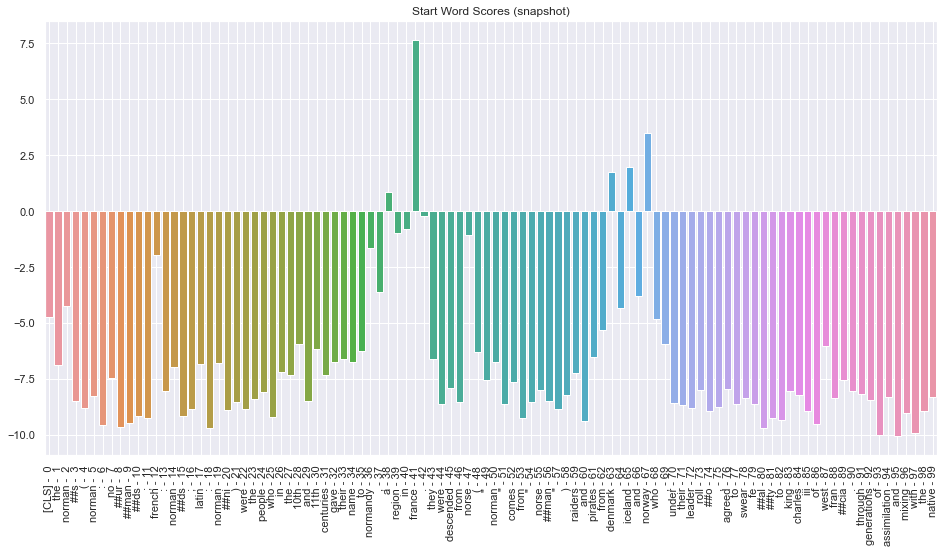

------------------------------


In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
first_n_words = 100
# val_contexts,val_questions
counter = 0
for input_ids,attention_mask, context, question in zip(val_encodings['input_ids'],val_encodings['attention_mask'],val_contexts,val_questions):
    model.eval()
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    input_ids = torch.tensor(input_ids).reshape(1,-1).to(device)
    attention_mask = torch.tensor(attention_mask).reshape(1,-1).to(device)
    output = model(input_ids,attention_mask = attention_mask)
    start_scores = output['start_logits']
    end_scores = output['end_logits']
    start_idx = torch.argmax(start_scores)
    end_idx = torch.argmax(end_scores)
    answer = tokens[start_idx]
    # Select the remaining answer tokens and join them with whitespace.
    for i in range(start_idx + 1, end_idx + 1):
        # If it's a subword token, then recombine it with the previous token.
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        # Otherwise, add a space then the token.
        else:
            answer += ' ' + tokens[i]
    print(f'Context {context}')
    print(f'question {question}')
    print(f'answer {answer}')
    # Use plot styling from seaborn.
    sns.set(style='darkgrid')
    # Increase the plot size and font size.
    plt.rcParams["figure.figsize"] = (16,8)
    s_scores = start_scores.cpu().detach().numpy().flatten()
    e_scores = end_scores.cpu().detach().numpy().flatten()
    # We'll use the tokens as the x-axis labels. In order to do that, they all need
    # to be unique, so we'll add the token index to the end of each one.
    token_labels = []
    for (i, token) in enumerate(tokens):
        token_labels.append('{:} - {:>2}'.format(token, i))
    # Create a barplot showing the start word score for all of the tokens.
    ax = sns.barplot(x=token_labels[0:first_n_words], y=s_scores[0:first_n_words], ci=None)
    # Turn the xlabels vertical.
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
    # Turn on the vertical grid to help align words to scores.
    ax.grid(True)
    plt.title('Start Word Scores (snapshot)')
    plt.show()
    print('-'*30)
    break
    counter+=1

Context The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
question In what country is Normandy located?
answer france .


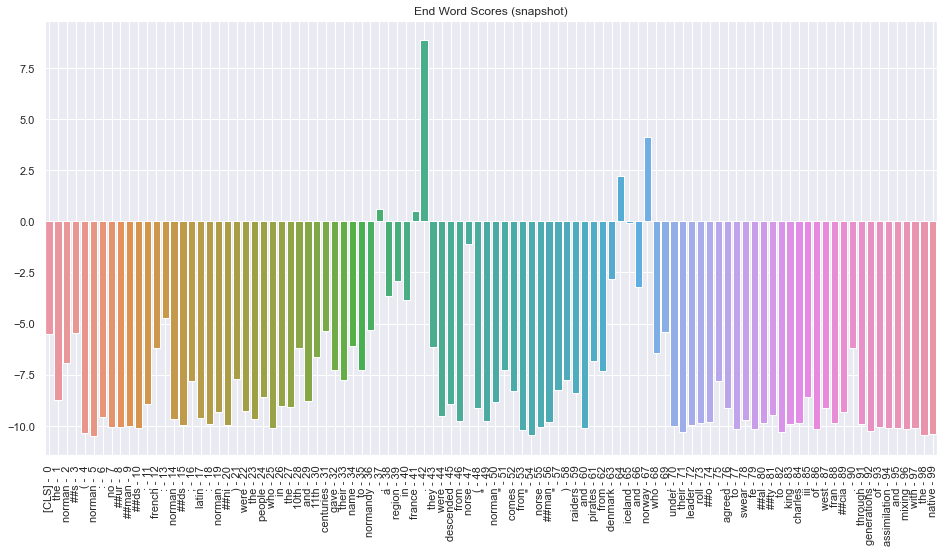

------------------------------


In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
first_n_words = 100
# val_contexts,val_questions
counter = 0
for input_ids,attention_mask, context, question in zip(val_encodings['input_ids'],val_encodings['attention_mask'],val_contexts,val_questions):
    model.eval()
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    input_ids = torch.tensor(input_ids).reshape(1,-1).to(device)
    attention_mask = torch.tensor(attention_mask).reshape(1,-1).to(device)
    output = model(input_ids,attention_mask = attention_mask)
    start_scores = output['start_logits']
    end_scores = output['end_logits']
    start_idx = torch.argmax(start_scores)
    end_idx = torch.argmax(end_scores)
    answer = tokens[start_idx]
    # Select the remaining answer tokens and join them with whitespace.
    for i in range(start_idx + 1, end_idx + 1):
        # If it's a subword token, then recombine it with the previous token.
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        # Otherwise, add a space then the token.
        else:
            answer += ' ' + tokens[i]
    print(f'Context {context}')
    print(f'question {question}')
    print(f'answer {answer}')
    # Use plot styling from seaborn.
    sns.set(style='darkgrid')
    # Increase the plot size and font size.
    plt.rcParams["figure.figsize"] = (16,8)
    s_scores = start_scores.cpu().detach().numpy().flatten()
    e_scores = end_scores.cpu().detach().numpy().flatten()
    # We'll use the tokens as the x-axis labels. In order to do that, they all need
    # to be unique, so we'll add the token index to the end of each one.
    token_labels = []
    for (i, token) in enumerate(tokens):
        token_labels.append('{:} - {:>2}'.format(token, i))
    # Create a barplot showing the start word score for all of the tokens.
    ax = sns.barplot(x=token_labels[0:first_n_words], y=e_scores[0:first_n_words], ci=None)
    # Turn the xlabels vertical.
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
    # Turn on the vertical grid to help align words to scores.
    ax.grid(True)
    plt.title('End Word Scores (snapshot)')
    plt.show()
    print('-'*30)
    break
    counter+=1

In [38]:
import json
output_file = r'C:\Users\prasr\Documents\Northeastern\Sem2\Stanford Question Answering Dataset - PROJECT\Question-Answering-model\data\processed\bert_fine_tuned.json'
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(distil_bert_answers, f, ensure_ascii=False, indent=4)